In [1]:
!pip install rdkit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 51.2 MB/s eta 0:00:00


In [2]:
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import shutil
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [5]:
df = pd.read_csv('/content/drive/MyDrive/07project/dataset.csv')
df

,PDB ID,SMILES,is_active
0,2VT4,OC(CNCCOc2ccc(n1ccnc1)cc2)CONC(C3CC3)C4CC4,1
1,1ZW5,C(CC(=O)[O-])[C@H](CS)C(=O)[O-],0
2,3FRJ,Cc1cccn2c1nc(c(c2=O)/C=C/3\C(=O)N(C(=S)S3)Cc4c...,0
3,3MAX,Cc1ccc(cc1Cl)Nc2nnc(s2)SCC(=O)Nc3c(ccs3)C(=O)N,0
4,2RGP,C[C@@H]1CCCC[C@H]1[NH2+][C@@H]2c3cc(c(cc3NC2=O...,0
...,...,...,...
29995,2OF2,Cc2ccc(C(=O)Nc1cccc(C(F)(F)F)c1)cc2C#Cc3cnc(N)nc3,1
29996,3EML,c1ccc(cc1)S(=O)(=O)Nc2cccc3c2n[nH]n3,0
29997,3L3M,NC(=O)c3cccc2CN(CC1CCNCC1)C(=O)c23,1
29998,3LAN,CCn1cnc2c(c1=O)c(c(s2)C(=O)Nc3ccc(cc3)O)C,0


In [6]:
train_pro = []
for i in range(20000):
  train_pro.append(df['PDB ID'][i])

In [7]:
# for i in range(len(train_pro)):
#   shutil.copy(f'/content/drive/MyDrive/07project/07Data/{train_pro[i]}.fasta','/content/drive/MyDrive/07project/training_pro_data/{:05d}_pro.fasta'.format(i + 1))

Coding proteins

In [8]:
import os
from collections import Counter
import numpy as np

def encode_proteins(folder_path, k):
    # Create a mapping from amino acids to numerical values
    amino_acid_map = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4,
                      "G": 5, "H": 6, "I": 7, "K": 8, "L": 9,
                      "M": 10, "N": 11, "P": 12, "Q": 13, "R": 14,
                      "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19}
    # Initialize the list to store the vectors
    vectors = []
    # Loop through each file in the folder
    for file in os.listdir(folder_path):
        if file.endswith(".fasta"):
            with open(os.path.join(folder_path, file), 'r') as f:
                # Read the sequence of amino acids from the file
                amino_acids = f.read().strip()
                # Create kmers of length k
                kmers = [amino_acids[i:i+k] for i in range(len(amino_acids) - k + 1)]
                # Count the frequency of each kmer
                kmer_counts = Counter(kmers)
                # Initialize the vector
                vector = np.zeros((20**k,))
                # Encode each kmer into a numerical value
                for kmer, count in kmer_counts.items():
                    index = 0
                    for amino_acid in kmer:
                        index = index * 20 + amino_acid_map[amino_acid]
                    vector[index] += count
                # Add the vector to the list
                vectors.append(vector)
    return np.array(vectors)


In [10]:
fasta_encoded = encode_proteins('/content/drive/MyDrive/07project/training_pro_data',2)

In [ ]:
# # padding with zero
# def pad_sequences(encoded_data, max_len, pad_value):
#     padded_data = np.zeros((len(encoded_data), max_len)) + pad_value
#     for i, seq in enumerate(encoded_data):
#         seq_len = len(seq)
#         if seq_len > max_len:
#             seq = seq[:max_len]
#         padded_data[i, :seq_len] = seq
#     return padded_data


In [11]:
fasta_encoded.shape

(20000, 400)

Coding SMILES

In [12]:
smiles_sequences = []
for i in range(20000):
  smiles_sequences.append(df['SMILES'][i])

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
def encode_smiles_with_fingerprint(smiles_list, fingerprint_radius):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, fingerprint_radius)
        fp_array = fp.ToBitString()
        fingerprints.append(fp_array)
    return fingerprints

# Example usage
fingerprint_radius = 2
smiles_encoded = encode_smiles_with_fingerprint(smiles_sequences, fingerprint_radius)

In [15]:
# Split each string into a list of characters
smiles_encoded = [list(string) for string in smiles_encoded]

# Convert each character to a floating-point number
smiles_encoded = [[float(char) for char in inner_list] for inner_list in smiles_encoded]

# Convert the list of floats to a 2 dimensional NumPy array
smiles_encoded = np.array(smiles_encoded, dtype=float)

In [16]:
smiles_encoded.shape

(20000, 2048)

In [17]:
# training_label y_train
y_train = []
for i in range(20000):
  y_train.append(df['is_active'][i])
y_train = np.array(y_train)

In [18]:
y_train = y_train.reshape(20000,1)

In [19]:
y_train.shape

(20000, 1)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
# Dataset class
class BinaryClassificationDataset(Dataset):
    def __init__(self, X_train_1, X_train_2, y_train):
        self.X_train_1 = X_train_1
        self.X_train_2 = X_train_2
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train_1[idx], self.X_train_2[idx], self.y_train[idx]

# Create the dataset object
train_dataset = BinaryClassificationDataset(fasta_encoded, smiles_encoded, y_train)

# Calculate the number of samples in the validation set
validation_split = 0.2
val_size = int(validation_split * len(train_dataset))

# Split the dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size])

# Create the dataloaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [24]:
print(len(train_dataloader))

250


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# define the network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # First branch for processing the first input
        self.conv1_1 = nn.Conv1d(1, 16, kernel_size=5)
        self.bn1_1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2_1 = nn.Conv1d(16, 32, kernel_size=5)
        self.bn2_1 = nn.BatchNorm1d(32)
        
        # Second branch for processing the second input
        self.conv1_2 = nn.Conv1d(1, 16, kernel_size=5)
        self.bn1_2 = nn.BatchNorm1d(16)
        self.pool2 = nn.MaxPool1d(2)
        self.conv2_2 = nn.Conv1d(16, 32, kernel_size=5)
        self.bn2_2 = nn.BatchNorm1d(32)
        
        # Third branch for processing the concatenated feature map
        self.conv1_3 = nn.Conv1d(32, 32, kernel_size=5)
        self.bn1_3 = nn.BatchNorm1d(32)
        self.pool3 = nn.MaxPool1d(2)
        self.conv2_3 = nn.Conv1d(32, 64, kernel_size=4)
        self.bn2_3 = nn.BatchNorm1d(64)
        
        # Fully connected layers
        self.fc1 = nn.Linear(9536, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        # First branch
        x1 = x1.reshape(-1,1,400)
        x1 = self.pool1(F.relu(self.bn1_1(self.conv1_1(x1))))
        x1 = self.pool1(F.relu(self.bn2_1(self.conv2_1(x1))))
        
        # Second branch
        x2 = x2.reshape(-1,1,2048)
        x2 = self.pool2(F.relu(self.bn1_2(self.conv1_2(x2))))
        x2 = self.pool2(F.relu(self.bn2_2(self.conv2_2(x2))))
        
        # Concatenate the feature maps
        x = torch.cat([x1, x2], 2)
        
        # Pass the concatenated feature maps to the third
        x = x.reshape(-1, 32, 606)
        x = self.pool3(F.relu(self.bn1_3(self.conv1_3(x))))
        x = self.pool3(F.relu(self.bn2_3(self.conv2_3(x))))
        x = x.flatten(1,-1)
        
        # Pass the processed feature map through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
    
        return x



# initialize the network
model = Net()


# define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

train_loss_list = []
val_loss_list = []
# train the network
num_epoch = 25
for epoch in range(num_epoch):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs1, inputs2, labels = data
        inputs1, inputs2, labels = inputs1.double(), inputs2.double(), labels.double() # convert inputs to float
        optimizer.zero_grad()
        outputs = model(torch.tensor(inputs1).to(torch.float32), torch.tensor(inputs2).to(torch.float32))
        loss = criterion(outputs.type(torch.float32), labels.type(torch.float32))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (torch.round(outputs) == labels).sum().item()
        total += labels.size(0)
    train_loss_list.append(running_loss/i+1)    
    train_acc = correct / total
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs1, inputs2, labels = data
            inputs1, inputs2, labels = inputs1, inputs2, labels
            outputs = model(torch.tensor(inputs1).to(torch.float32), torch.tensor(inputs2).to(torch.float32))
            val_loss += criterion(outputs.type(torch.float32), labels.type(torch.float32)).item()
            val_correct += (torch.round(outputs) == labels).sum().item()
            val_total += labels.size(0)
        val_loss_list.append(val_loss/i+1)
        val_acc = val_correct / val_total
    print("Epoch: {}/{} | Train Loss: {:.4f} | Val Loss: {:.4f}"
          .format(epoch + 1, num_epoch, train_loss_list[-1], val_loss_list[-1]))



<ipython-input-25-401a2252e94d>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(inputs1).to(torch.float32), torch.tensor(inputs2).to(torch.float32))
<ipython-input-25-401a2252e94d>:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(inputs1).to(torch.float32), torch.tensor(inputs2).to(torch.float32))


Epoch: 1/25 | Train Loss: 1.4900 | Val Loss: 1.4008
Epoch: 2/25 | Train Loss: 1.3448 | Val Loss: 1.3339
Epoch: 3/25 | Train Loss: 1.2906 | Val Loss: 1.2604
Epoch: 4/25 | Train Loss: 1.2493 | Val Loss: 1.2255
Epoch: 5/25 | Train Loss: 1.2254 | Val Loss: 1.2088
Epoch: 6/25 | Train Loss: 1.2020 | Val Loss: 1.2080
Epoch: 7/25 | Train Loss: 1.1809 | Val Loss: 1.1879
Epoch: 8/25 | Train Loss: 1.1696 | Val Loss: 1.1858
Epoch: 9/25 | Train Loss: 1.1556 | Val Loss: 1.1704
Epoch: 10/25 | Train Loss: 1.1432 | Val Loss: 1.1722
Epoch: 11/25 | Train Loss: 1.1283 | Val Loss: 1.1645
Epoch: 12/25 | Train Loss: 1.1178 | Val Loss: 1.1913
Epoch: 13/25 | Train Loss: 1.1080 | Val Loss: 1.1617
Epoch: 14/25 | Train Loss: 1.0991 | Val Loss: 1.1595
Epoch: 15/25 | Train Loss: 1.0926 | Val Loss: 1.1565
Epoch: 16/25 | Train Loss: 1.0833 | Val Loss: 1.1556
Epoch: 17/25 | Train Loss: 1.0766 | Val Loss: 1.1533
Epoch: 18/25 | Train Loss: 1.0802 | Val Loss: 1.1745
Epoch: 19/25 | Train Loss: 1.0659 | Val Loss: 1.1593
Ep

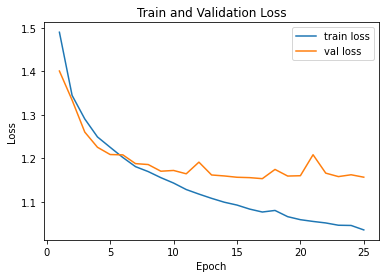

In [26]:
epochs = range(1, num_epoch + 1)

sns.lineplot(x=epochs, y=train_loss_list, label="train loss")
sns.lineplot(x=epochs, y=val_loss_list, label="val loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [27]:
# Save the entire model to disk
torch.save(model.state_dict(), "/content/drive/MyDrive/07project/model_new.pt")
# torch.save(model.state_dict(), "model_new.pt")